<a href="https://colab.research.google.com/github/harikishorep122/UNET/blob/main/RSNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transferring data from kaggle to gdrive

In [ ]:

from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"harikishorep","key":"f8ba065fc9e1bacbeb0d6f5644a40eaf"}'}

In [ ]:
! mkdir "/content/gdrive/My Drive/RSNA"
! cp kaggle.json "/content/gdrive/My Drive/RSNA"
! chmod 600 ~/.kaggle/kaggle.json
!pip install --upgrade --force-reinstall --no-deps kaggle
! kaggle datasets list
!kaggle competitions download -c rsna-pneumonia-detection-challenge
!unzip rsna-pneumonia-detection-challenge.zip -d "/content/gdrive/My Drive/RSNA"

In [ ]:
!pip install pydicom
! mkdir "/content/gdrive/My Drive/RSNA/train1"
import pydicom as dicom
import cv2
import os
folder_path = '/content/gdrive/My Drive/RSNA/stage_2_train_images'
jpg_path = "/content/gdrive/My Drive/RSNA/train1"
images_path = os.listdir(folder_path)
for n, image in enumerate(images_path):
    ds = dicom.dcmread(os.path.join(folder_path, image))
    pixel_array_numpy = ds.pixel_array
    image = image.replace('.dcm', '.jpg')
    cv2.imwrite(os.path.join(jpg_path, image), pixel_array_numpy)
    if n % 1000 == 0:
        print('{} image converted'.format(n))

##Creating Mask images

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import csv
import os

mask_path = "/content/gdrive/My Drive/RSNA/masks/"
csv_path = "/content/gdrive/My Drive/RSNA/stage_2_train_labels.csv"

sheet = open(csv_path, newline='')

images_path = os.listdir("/content/gdrive/My Drive/RSNA/train")
images_path = [os.path.splitext(x)[0] for x in images_path]
images_path = [x.strip() for x in images_path]
i=1
for image_name in images_path: 
    sheet = open(csv_path, newline='')
    reader = csv.reader(sheet)
    for row in reader:
      if row[0]==image_name:
        print(image_name)
        print(i)
        i+=1
        if row[5]=='1':
          pt1 = (int(row[1].split('.')[0]),int(row[2].split('.')[0]))
          pt2 = int(row[1].split('.')[0])+int(row[3].split('.')[0]),int(row[2].split('.')[0])+int(row[4].split('.')[0])

          if os.path.isfile(mask_path+image_name+'.jpg')==True:       
            img = cv2.imread(mask_path+image_name+'.jpg')
          else:
            img = np.zeros((1024, 1024, 3), dtype = "uint8")
          cv2.rectangle(img, pt1, pt2, (255,255,255), -1)
          cv2.imwrite(mask_path+image_name+'.jpg', img)  
          #cv2_imshow(img)
        else:  
          img = np.zeros((1024, 1024, 3), dtype = "uint8")
          cv2.imwrite(mask_path+row[0]+'.jpg', img)
    sheet.close()

In [ ]:
import os
jpg_path = "/content/gdrive/My Drive/RSNA/stage_2_train_images"
images_path = os.listdir(jpg_path)
len(images_path)

26684

In [ ]:
images_path = "/content/gdrive/My Drive/RSNA/train"
ids = next(os.walk(images_path))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  4671


#Loading images and masks into arrays

In [ ]:
# tqdm is used to display the progress bar
images_path = "/content/gdrive/My Drive/RSNA/train/"
mask_path = "/content/gdrive/My Drive/RSNA/masks/"
err =1
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img(images_path+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (256, 256, 1), mode = 'constant', preserve_range = True)
    # Load masks
    try:
      mask = load_img(mask_path+id_, grayscale=True)
      mask = img_to_array(mask)
      mask = resize(mask, (256, 256, 1), mode = 'constant', preserve_range = True)
    except Exception as e:
      err+=1
      #print(e)
      continue  
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0
print(err)

#Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Importing necessary packages

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
!pip install pydicom
import pydicom as dicom
import cv2
import os
from google.colab.patches import cv2_imshow
import csv
import keras

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.metrics import MeanIoU
from keras.utils import to_categorical
from tensorflow.keras import layers
from keras.callbacks import CSVLogger
import datetime

Set some parameters

In [ ]:
im_height = 256 
im_width = 256

#Data generator class for efficient data flow

In [ ]:
class DataGenerator(keras.utils.Sequence):
    # Inherites keras.utils.Sequence for using functionalities such as multiprocessing
    'Generates data for Keras'
    def __init__(self, folder_path, csv_path, ratio, batch_size=32, img_height=256, img_width=256, shuffle=True, val= False):
        'Initialization'
        self.batch_size = batch_size
        self.folder_path = folder_path
        self.csv_path = csv_path
        self.ratio = ratio
        if val == False:
          self.image_names = os.listdir(folder_path)
          random.seed(2)
          random.shuffle(self.image_names)
          self.image_names = self.image_names[0:int(ratio*len(self.image_names))]
        else:
          self.image_names = os.listdir(folder_path)
          random.seed(2)
          random.shuffle(self.image_names)
          self.image_names = self.image_names[int(ratio*len(self.image_names)):-1]
        self.img_height = img_height
        self.img_width = img_width
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_names) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.image_names[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_names))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size, self.img_height, self.img_width, 1), dtype=np.float32)
        y = np.zeros((self.batch_size, self.img_height, self.img_width, 2), dtype=np.float32)

        # Generate data
        for n, image_name in enumerate(list_IDs_temp):
            ds = dicom.dcmread(os.path.join(self.folder_path, image_name))
            pixel_array_numpy = ds.pixel_array
            x_img = pixel_array_numpy
            x_img = resize(x_img, (self.img_height, self.img_width, 1), mode = 'constant', preserve_range = True)

            # Draw masks
            sheet = open(self.csv_path, newline='')
            reader = csv.reader(sheet)
            mask = np.zeros((1024, 1024, 1), dtype = "uint8")

            image_name = os.path.splitext(image_name)[0]
            image_name = image_name.strip()

            for row in reader:
              if row[0]==image_name:
                if row[5]=='1':
                  pt1 = (int(row[1].split('.')[0]),int(row[2].split('.')[0]))
                  pt2 = (int(row[1].split('.')[0])+int(row[3].split('.')[0]),int(row[2].split('.')[0])+int(row[4].split('.')[0]))
                  cv2.rectangle(mask, pt1, pt2, 255, -1)     
            sheet.close()
            mask = resize(mask, (self.img_height, self.img_width, 1), mode = 'constant', preserve_range = True)
            mask.astype(int)
            mask /= 255
            mask = tf.keras.utils.to_categorical(mask, num_classes=2, dtype='float32')
            #cv2_imshow(x_img)
            #cv2_imshow(mask)

            # Save images
            X[n] = x_img
            y[n] = mask

        return X, y

##Creating UNET Model

In [ ]:
# Datasets
images_path = "/content/gdrive/My Drive/RSNA/stage_2_train_images"
csv_path = "/content/gdrive/My Drive/RSNA/stage_2_train_labels.csv"

In [ ]:
# Generators
training_generator = DataGenerator(images_path, csv_path, 0.8, batch_size=32, img_height=256, img_width=256, shuffle=True, val=False)
validation_generator = DataGenerator(images_path, csv_path, 0.8, batch_size=32, img_height=256, img_width=256, shuffle=True, val=True)

Visualize any random image along with the mask

In [ ]:
gen = DataGenerator(images_path,csv_path, 0.8, batch_size = 32, img_height = 256, img_width = 256, shuffle = True, val = False)
x, y = gen.__getitem__(0)

In [ ]:
# Visualize any random image along with the mask
ix = random.randint(0, len(x)-1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))

ax1.imshow(x[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax1.set_title('image')

ax2.imshow(y[ix][0].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('mask')

ax3.imshow(y[ix][1].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax3.set_title('mask')

Functions for dice coefficient metric and loss

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
def dice_coef(y_true, y_pred):

  smooth=1.0e-6
  #y_true_f_1 = tf.keras.backend.flatten(y_true[:,:,:,0])
  #y_pred_f_1 = tf.keras.backend.flatten(y_pred[:,:,:,0])
  y_true_f_2 = tf.keras.backend.flatten(y_true[:,:,:,1])
  y_pred_f_2 = tf.keras.backend.flatten(y_pred[:,:,:,1])
  #intersection_1 = tf.keras.backend.sum(y_true_f_1 * y_pred_f_1)
  intersection_2 = tf.keras.backend.sum(y_true_f_2 * y_pred_f_2)
  #union_1 = tf.keras.backend.sum(y_true_f_1) + tf.keras.backend.sum(y_pred_f_1)
  union_2 = tf.keras.backend.sum(y_true_f_2) + tf.keras.backend.sum(y_pred_f_2)
  
  score = 2*(intersection_2+smooth)/(union_2+smooth)
  return score
  
def DiceLoss(y_true, y_pred):

  score = dice_coef(y_true, y_pred)
  
  return 1 - score

#Model architecture

In [ ]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (1,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
#keras.backend.clear_session()

In [ ]:
img_size = (im_height, im_width)
num_classes = 2
model = get_model(img_size, num_classes)
model.compile(optimizer=Adam(), loss = DiceLoss, metrics=[MeanIoU(num_classes=2), dice_coef]) 

#Model Summary

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

Callbacks for the model

In [ ]:
#callbacks = [ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),]
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience = 52, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint("/content/gdrive/My Drive/RSNA/best_model.h5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', save_freq = 'epoch')
csv_logger = CSVLogger("/content/gdrive/My Drive/RSNA/training.csv", separator=',', append=True)
logdir = "/content/gdrive/My Drive/RSNA/" + "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


callbacks = [earlystopping, checkpoint, csv_logger, tensorboard_callback]

# Training the model

In [ ]:
#results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks, validation_data=(X_valid, y_valid))

results = model.fit(training_generator,
                    validation_data=validation_generator,
                    epochs = 50,
                    callbacks=callbacks)

#Saving the model to drive

In [ ]:
model.save_weights('/content/gdrive/My Drive/RSNA/unet_model.h5')

#Plotting learning curve

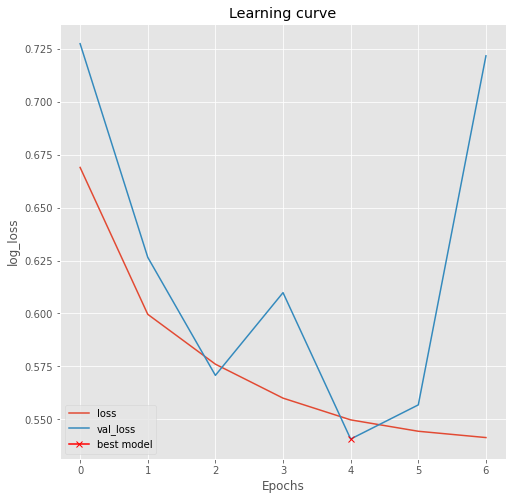

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

#Plotting Dice coefficient curve

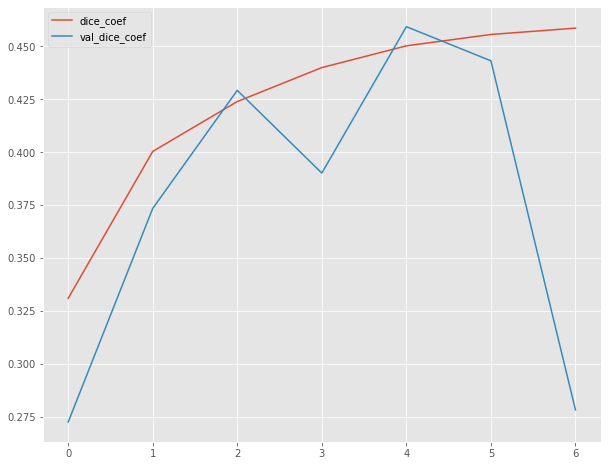

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(results.history['dice_coef'],label='dice_coef')
plt.plot(results.history['val_dice_coef'],label='val_dice_coef')
plt.legend()

#Evaluate on validation set

In [ ]:
model.evaluate(validation_generator, verbose=1)

166/166 [==============================] - 704s 4s/step - loss: 0.0242 - mean_io_u: 0.9528 - dice_coef: 0.9758


[0.02419264428317547, 0.9527525901794434, 0.9758071899414062]

Loading saved model

In [ ]:
from keras.models import load_model

model = load_model('/content/gdrive/My Drive/RSNA/best_model.h5', compile = False)

#Predictions on train and validation sets

In [ ]:
def plot_sample1():
    """Function to plot the results"""
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 20))
    folder_path = '/content/gdrive/My Drive/RSNA/stage_2_train_images'
    csv_path = "/content/gdrive/My Drive/RSNA/stage_2_train_labels.csv" 
    #loading a random image

    ix = random.randint(0, len(ids))
    image_name = ids[ix]
    ds = dicom.dcmread(os.path.join(folder_path, image_name))
    pixel_array_numpy = ds.pixel_array
    x_img = pixel_array_numpy

    # Draw masks
    mask = np.zeros((1024, 1024, 1), dtype = "uint8")

    image_name = os.path.splitext(image_name)[0]
    image_name = image_name.strip()

    sheet = open(csv_path, newline='')
    reader = csv.reader(sheet)
    for row in reader:
        if row[0]==image_name:
          if row[5]=='1':
            pt1 = (int(row[1].split('.')[0]),int(row[2].split('.')[0]))
            pt2 = (int(row[1].split('.')[0])+int(row[3].split('.')[0]),int(row[2].split('.')[0])+int(row[4].split('.')[0]))
            cv2.rectangle(mask, pt1, pt2, (255), -1)     
    sheet.close()
    mask = resize(mask, (im_height, im_width, 1), mode = 'constant', preserve_range = True)

    #ground truth plot---------------------------------------------------------

    ax[0].imshow(x_img, cmap='gray', interpolation = 'bilinear')
    #ax[0].contour(mask.squeeze(), colors='black', levels=[0.5])
    ax[0].set_title('x_ray ground truth')

    #Mask ground truth plot---------------------------------------------------

    ax[1].imshow(mask.squeeze(), cmap='gray')
    ax[1].set_title('Mask ground truth')

    #Predicted mask plot --------------------------------------------------

    x_img = resize(x_img, (256, 256), mode = 'constant', preserve_range = True)
    img = np.expand_dims(x_img, axis=-1)
    x_test= np.zeros((1, 256, 256, 1), dtype=np.uint8)
    x_test[0]=img

    pred_test= model.predict(x_test, verbose=1)
    pred_test = np.argmax(pred_test, axis=-1)
    pred_test = pred_test[0]
    print(pred_test.shape)
    for i in range(pred_test.shape[0]):
            for j in range(pred_test.shape[1]):
                if pred_test[i][j] == 1:
                    pred_test[i][j] = 255
                else:
                    pred_test[i][j] = 0
    pred_test = cv2.merge((pred_test,pred_test, pred_test))
    '''
    contours, hierarchy = cv2.findContours(pred_test,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for each_contour in contours:
        x,y,w,h = cv2.boundingRect(each_contour)
        cv2.rectangle(pred_test,(x,y),(x+w,y+h),(0,0,255),4)
        print (x,y,w,h)
    '''
    ax[2].imshow(pred_test, cmap='gray')
    
    ax[2].set_title('Predicted x_ray')

#Predictions on training set

In [ ]:
ids = os.listdir(images_path)
print(len(ids))

26684


1/1 [==============================] - 0s 23ms/step
(256, 256)
1/1 [==============================] - 0s 27ms/step
(256, 256)
1/1 [==============================] - 0s 24ms/step
(256, 256)
1/1 [==============================] - 0s 34ms/step
(256, 256)
1/1 [==============================] - 0s 25ms/step
(256, 256)
1/1 [==============================] - 0s 25ms/step
(256, 256)
1/1 [==============================] - 0s 26ms/step
(256, 256)
1/1 [==============================] - 0s 24ms/step
(256, 256)
1/1 [==============================] - 0s 26ms/step
(256, 256)
1/1 [==============================] - 0s 23ms/step
(256, 256)


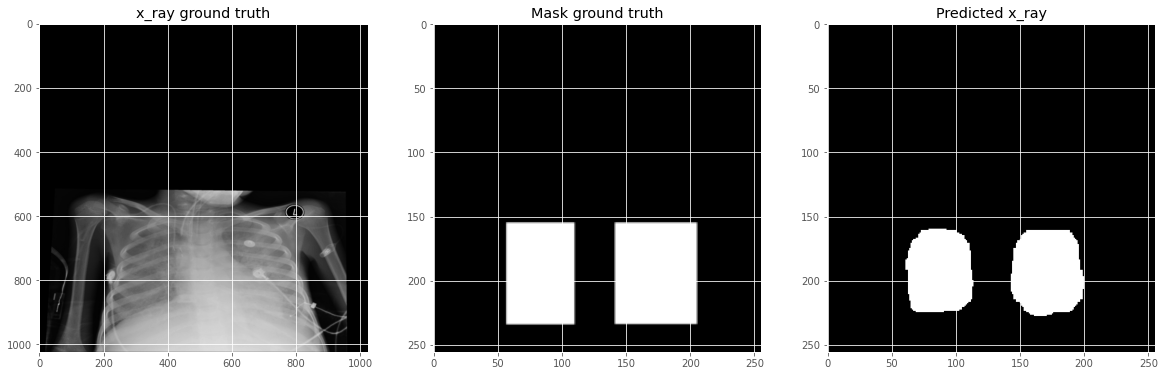

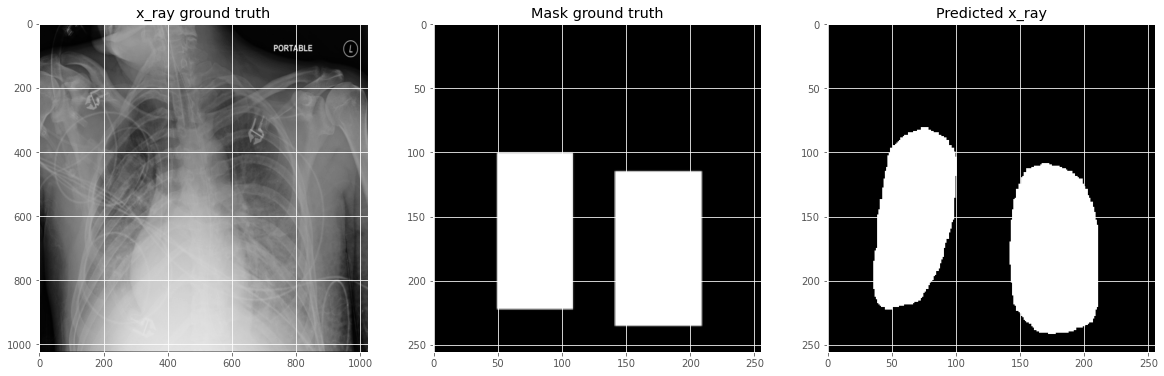

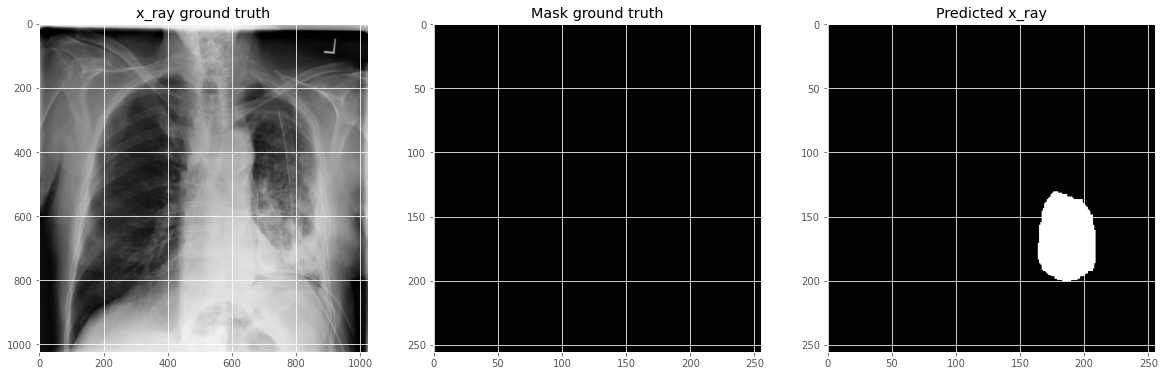

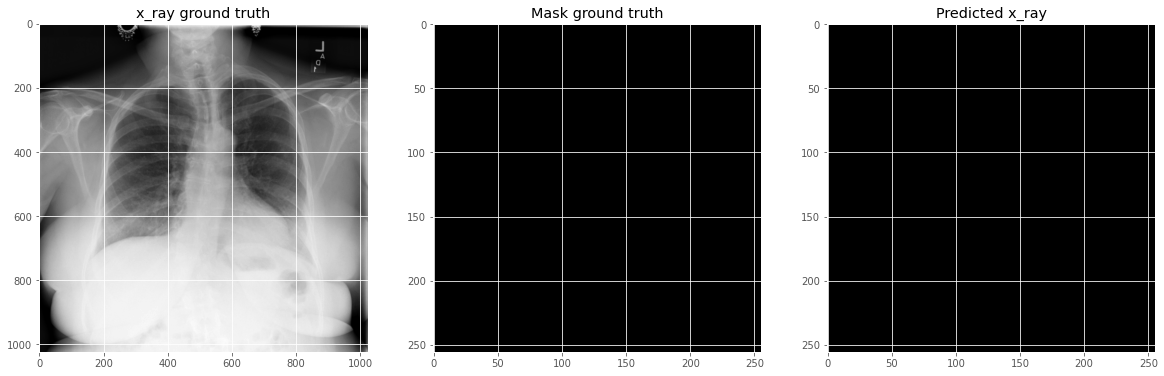

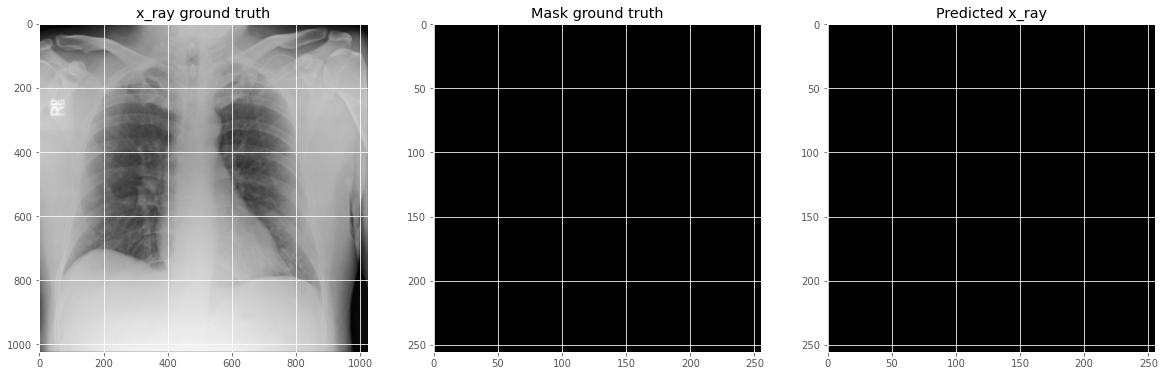

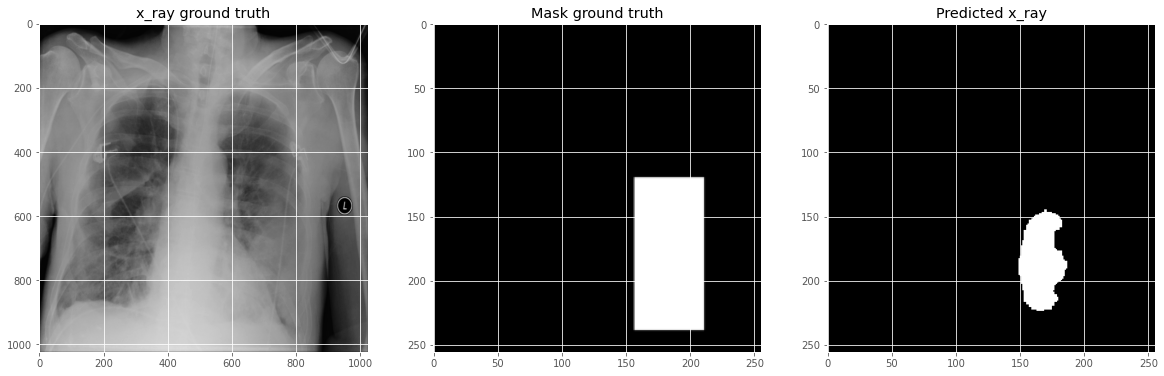

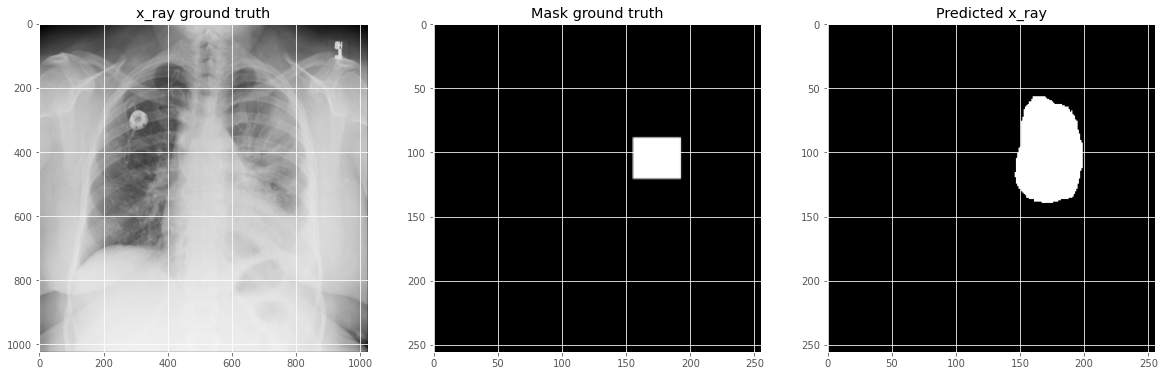

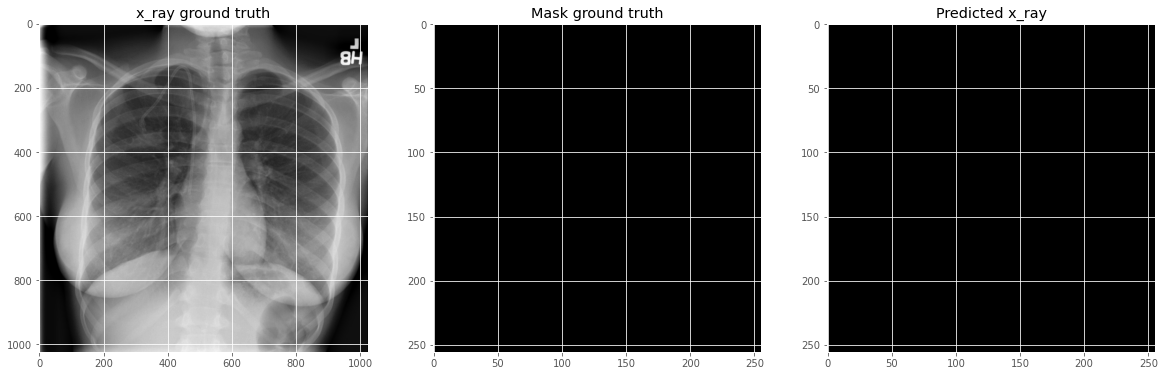

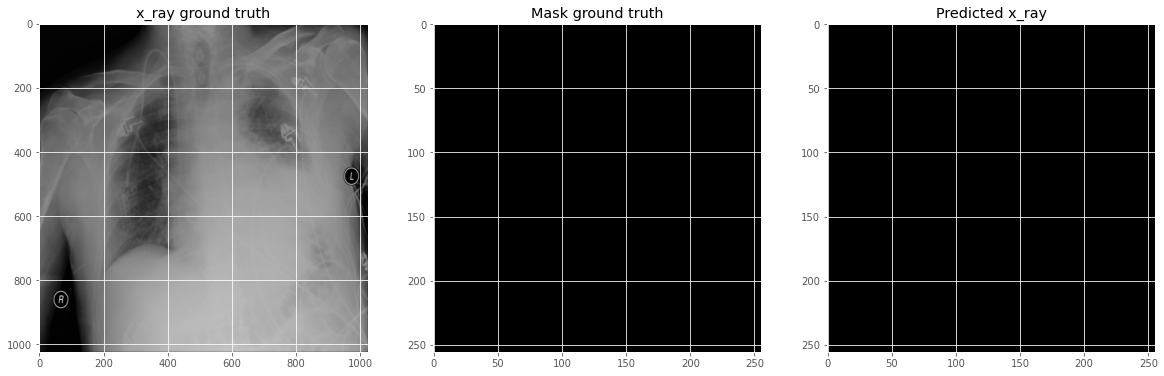

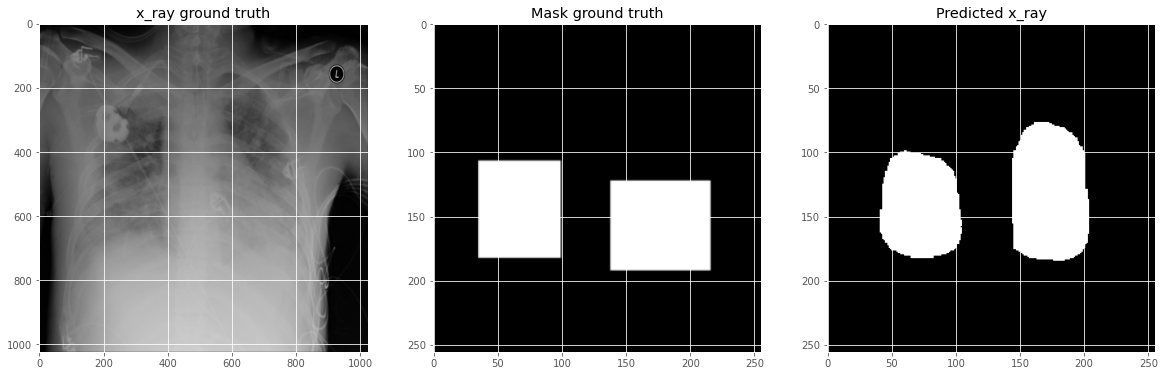

In [ ]:
for i in range(10):plot_sample1()

1/1 [==============================] - 0s 26ms/step
(256, 256)
1/1 [==============================] - 0s 24ms/step
(256, 256)
1/1 [==============================] - 0s 23ms/step
(256, 256)
1/1 [==============================] - 0s 25ms/step
(256, 256)
1/1 [==============================] - 0s 24ms/step
(256, 256)
1/1 [==============================] - 0s 33ms/step
(256, 256)
1/1 [==============================] - 0s 31ms/step
(256, 256)
1/1 [==============================] - 0s 30ms/step
(256, 256)
1/1 [==============================] - 0s 24ms/step
(256, 256)
1/1 [==============================] - 0s 24ms/step
(256, 256)


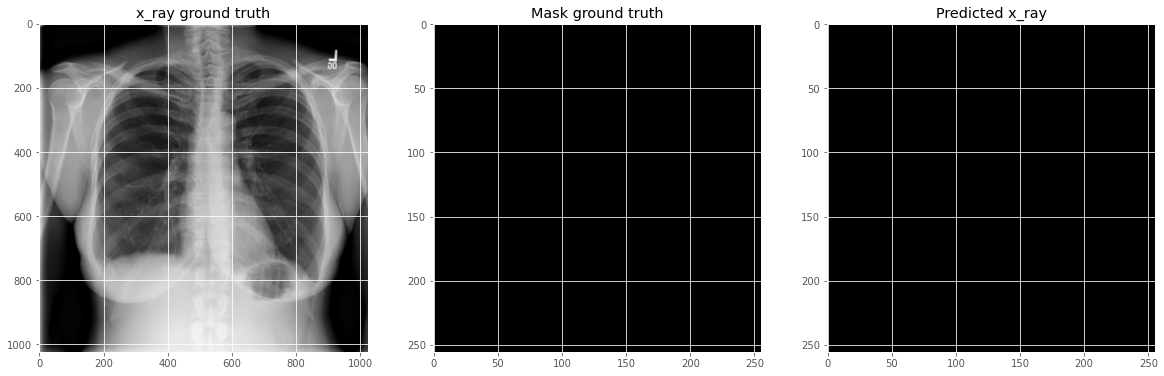

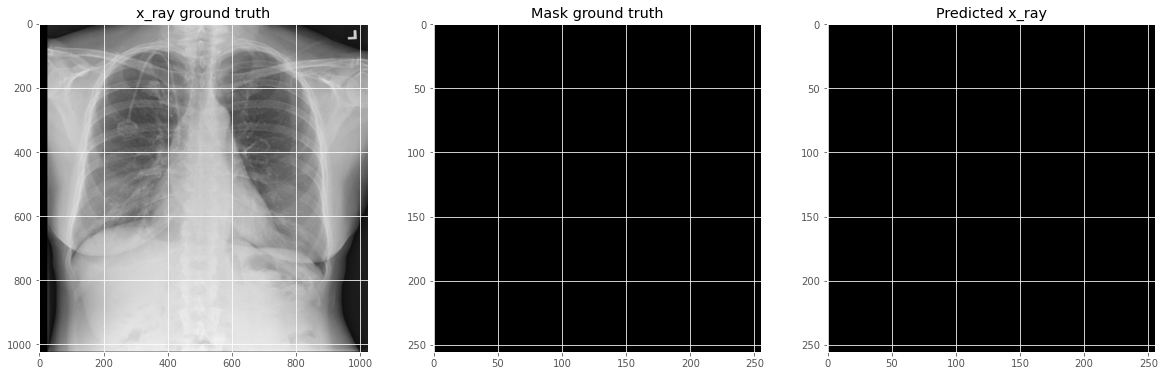

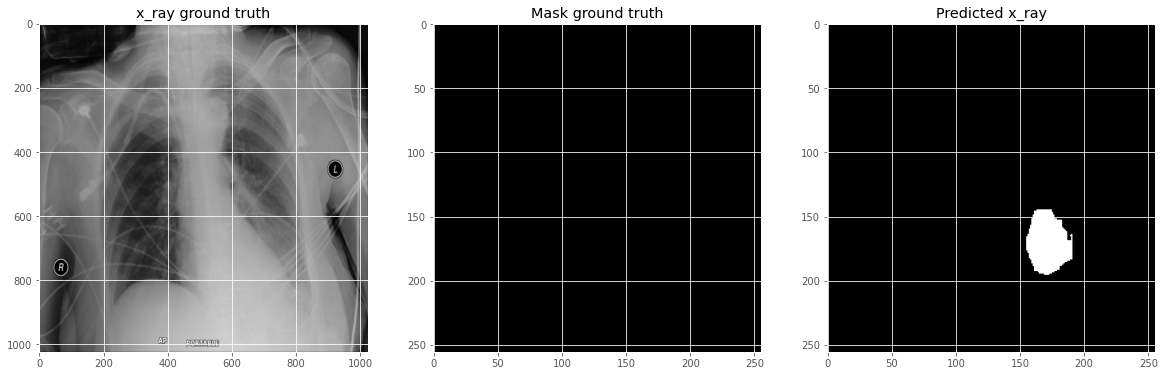

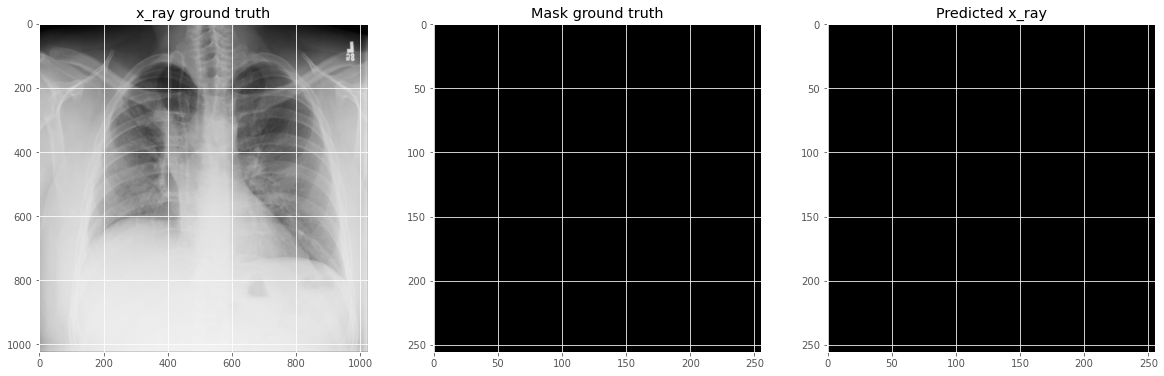

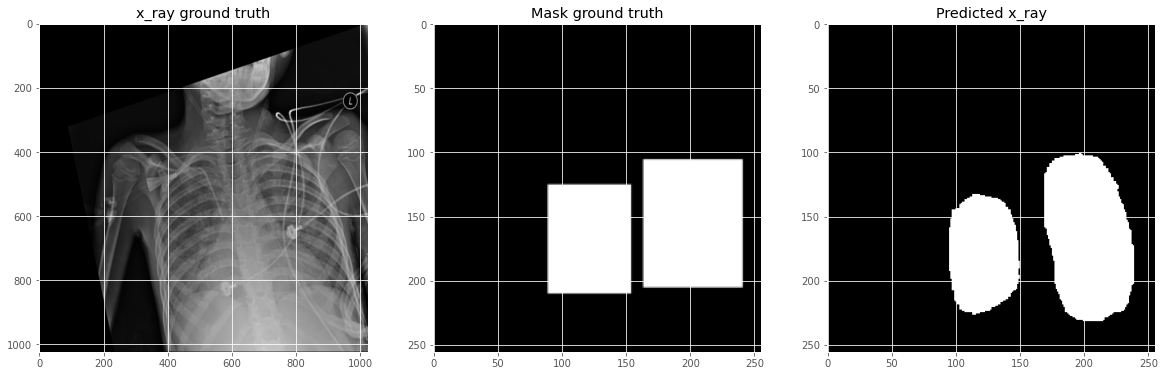

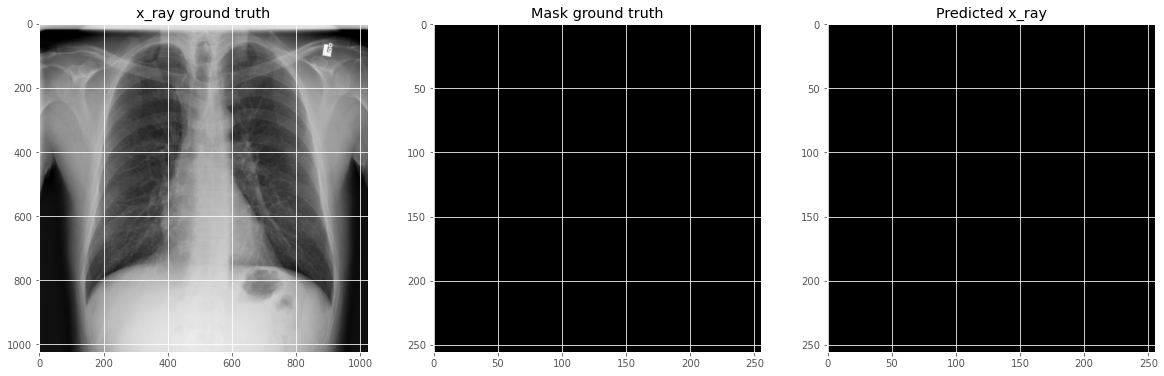

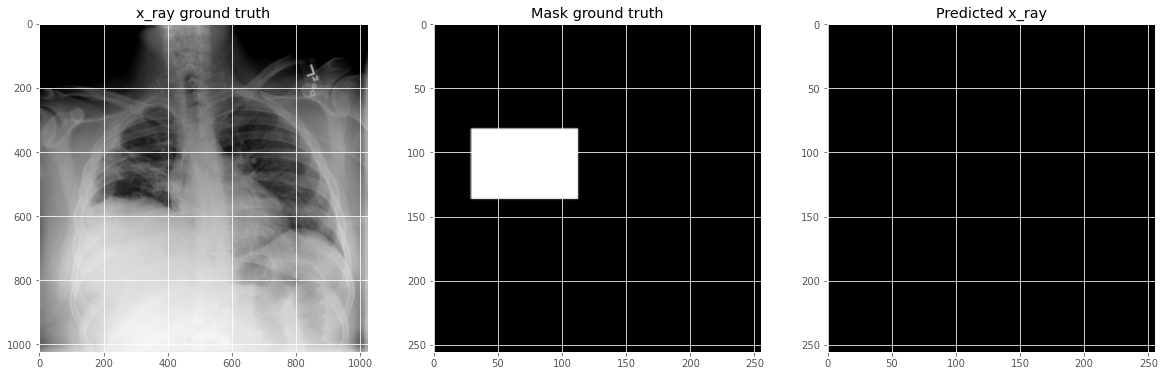

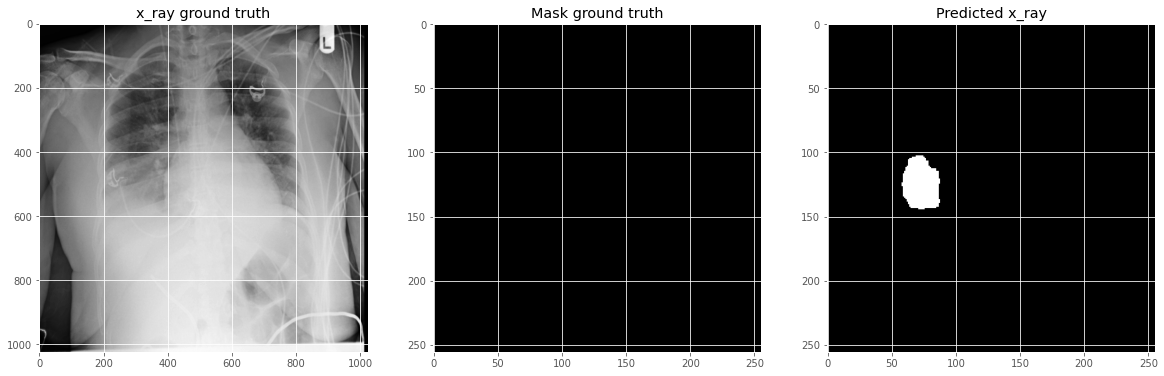

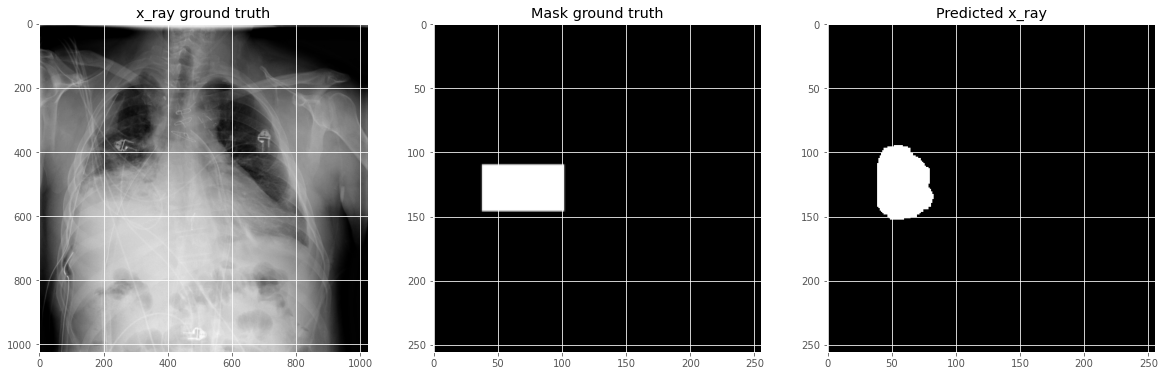

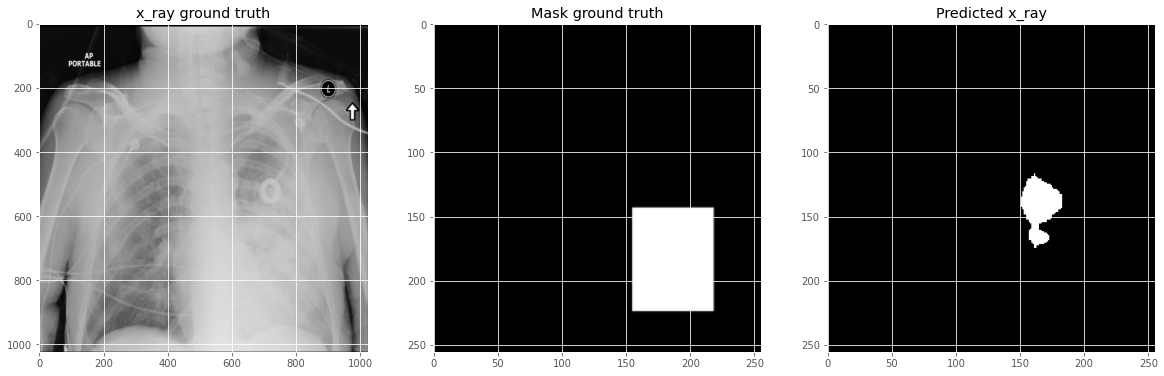

In [ ]:
for i in range(10):plot_sample1()

1/1 [==============================] - 0s 24ms/step
(256, 256)
1/1 [==============================] - 0s 26ms/step
(256, 256)
1/1 [==============================] - 0s 24ms/step
(256, 256)
1/1 [==============================] - 0s 25ms/step
(256, 256)
1/1 [==============================] - 0s 27ms/step
(256, 256)
1/1 [==============================] - 0s 23ms/step
(256, 256)
1/1 [==============================] - 0s 27ms/step
(256, 256)
1/1 [==============================] - 0s 22ms/step
(256, 256)
1/1 [==============================] - 0s 23ms/step
(256, 256)
1/1 [==============================] - 0s 18ms/step
(256, 256)


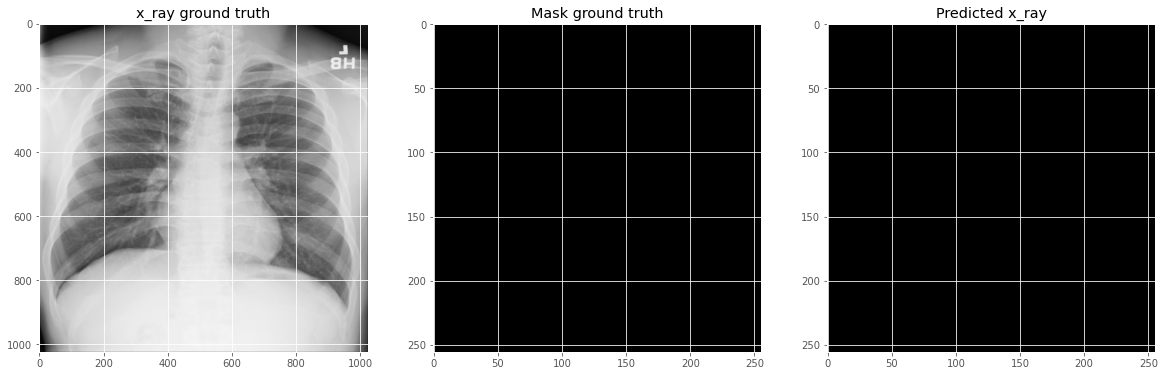

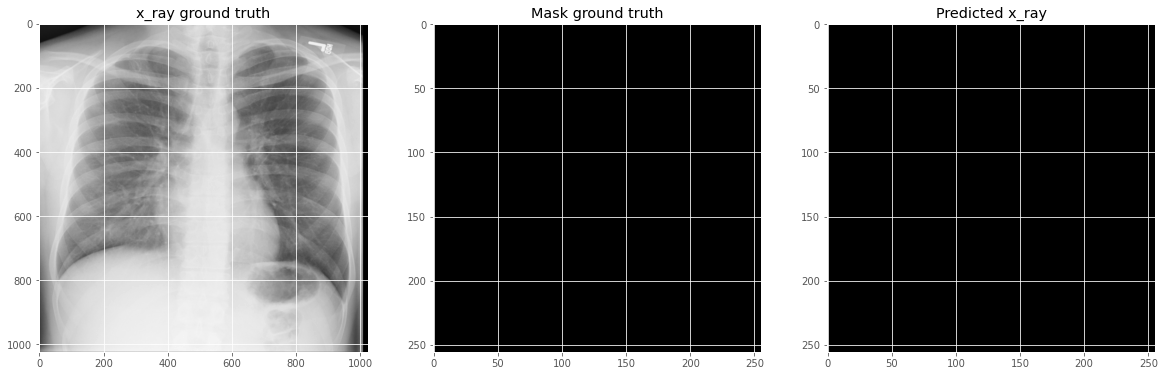

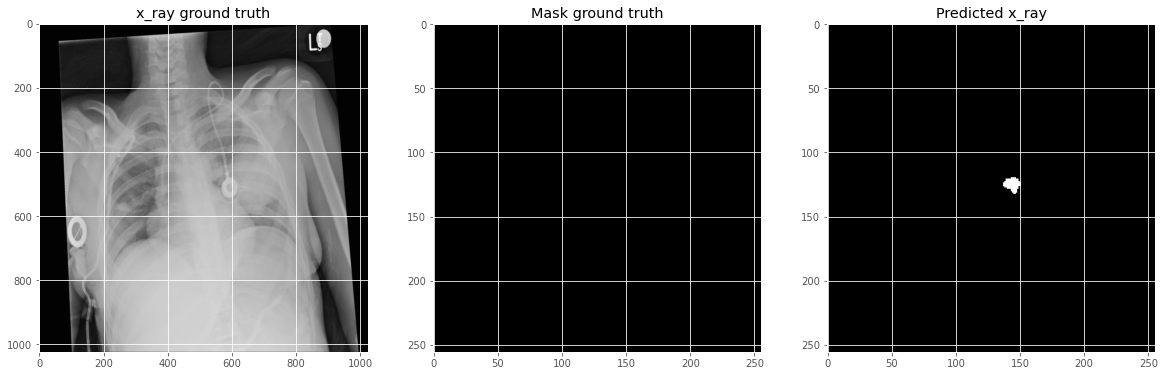

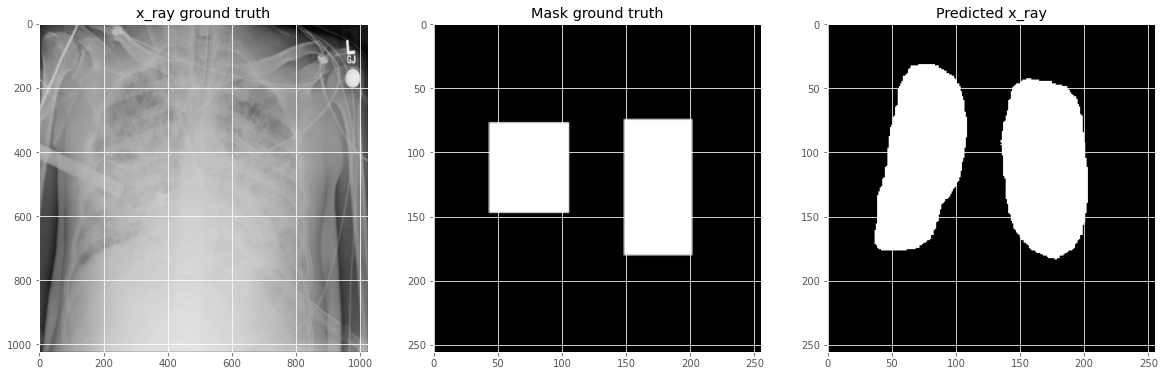

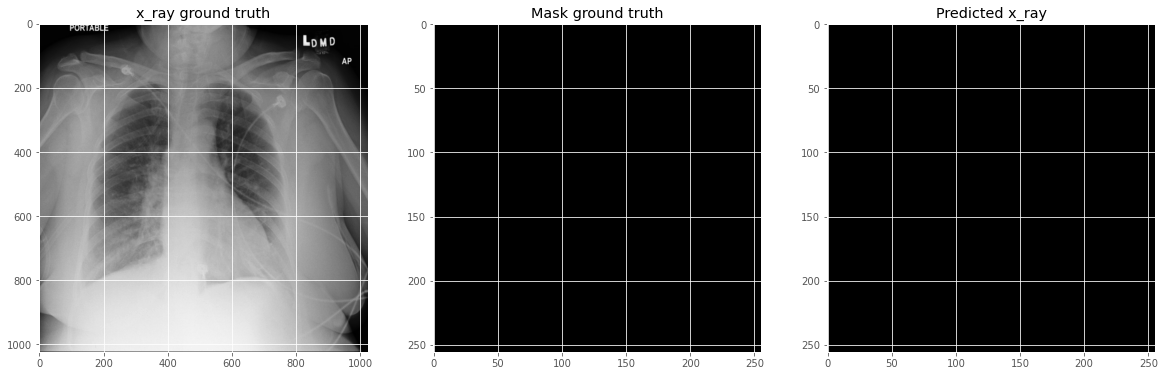

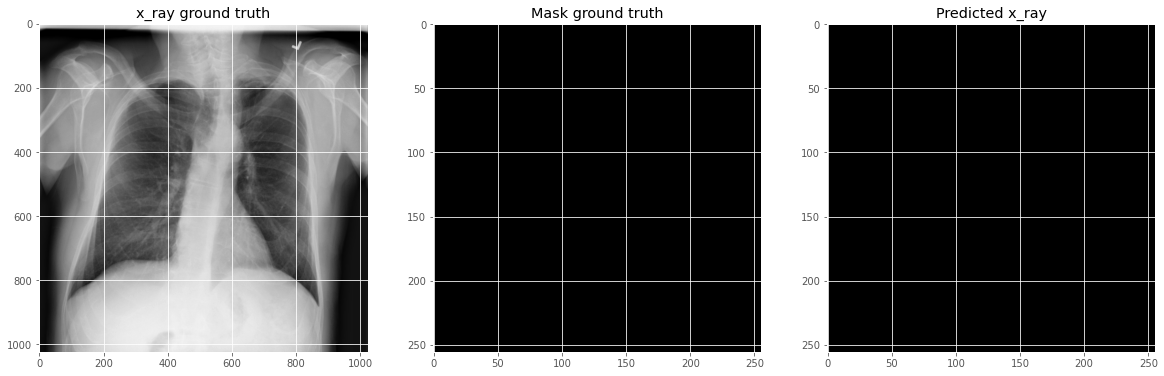

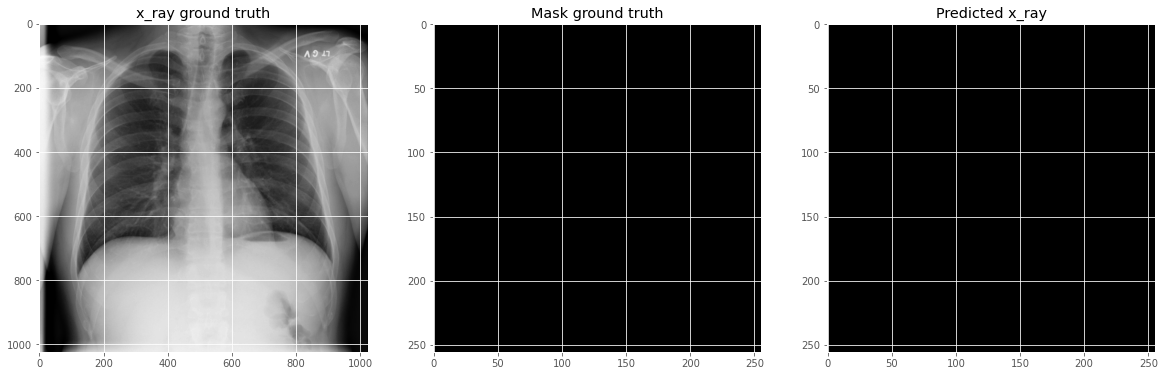

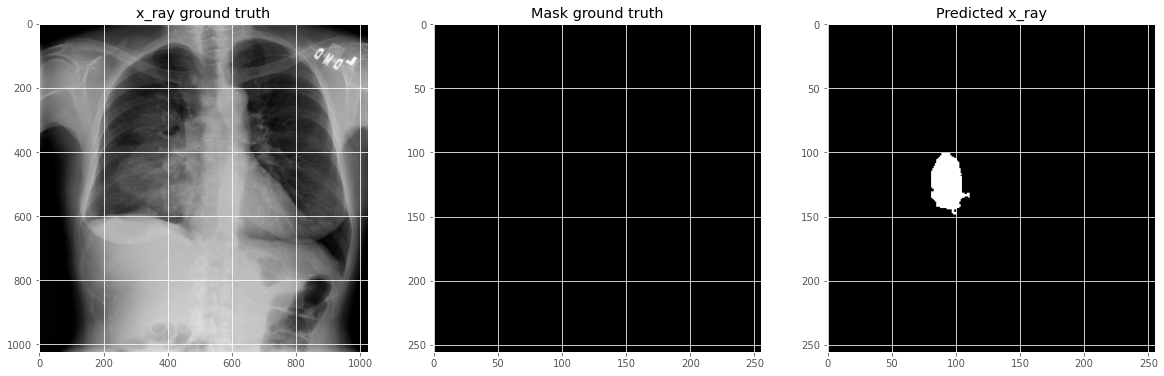

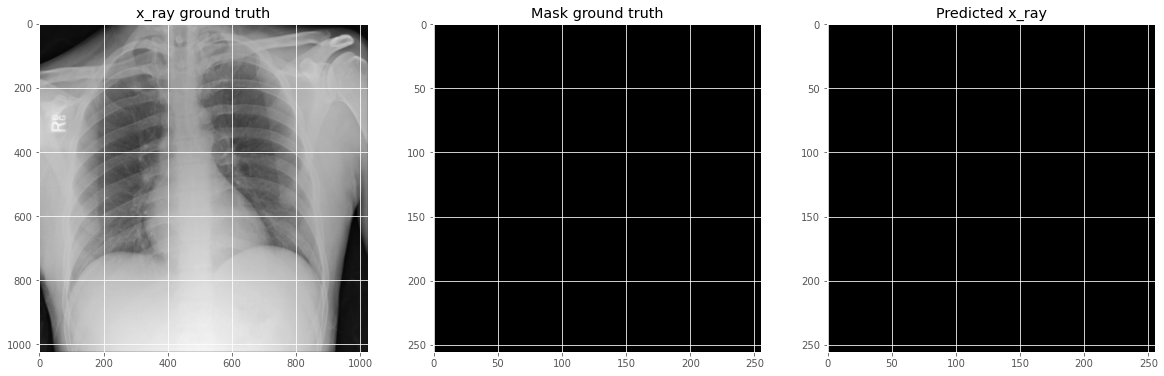

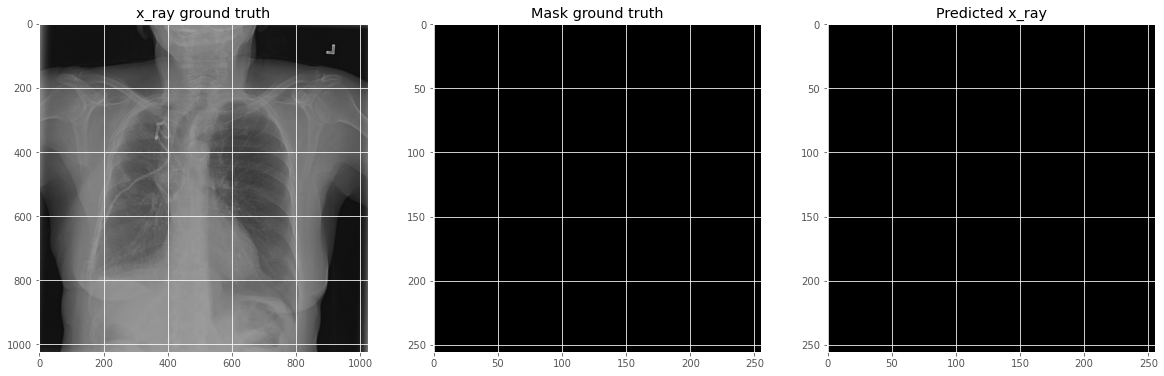

In [ ]:
for i in range(10):plot_sample1()

#Plotting mean IoU curve

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(results.history['mean_iou'],label='iou')
plt.legend()

In [ ]:
while True: pass